#**09-2 순환 신경망으로 IMDB 리뷰 분류하기**

# IMDB 리뷰 데이터셋
> IMDB 리뷰 데이터 셋은 감상평에 따라 긍정과 부정으로 분류해 놓은 데이터 셋으로 총 50000개의 샘플을 훈련 데이터와 테스터 데이터에 25000개씩 나눔

> 자연어 처리(natural language processing, NPL)는 컴퓨터를 사용해 인간의 언어를 처리하는 분야
- 자연어 처리 분야에서는 훈련 데이터를 종종 말뭉치(corpus)라고 부름
 -IMDV 데이터 셋은 하나의 말뭉치에 해당

> 컴퓨터에서 처리하는 모든 것은 숫자 데이터이므로, 텍스트 데이터의 경우 단어를 숫자 데이터로 바꾸기 위해 일반적으로 등장하는 단어마다 고유한 정수를 부여하는 방법을 사용함

예시

<pre>He follows the cat. He loves the cat.
10   11    12  13   10   14   12 13</pre>

> 동일한 단어에는 동일한 정수가 매핑되고, 매핑되는 정수는 단어의 의미나 크기와 관련 없음

> 일반적으로 영어 문장은 모두 소문자로 바꾸고 구둣점을 삭제한 다음 공백을 기준으로 분리
- 이렇게 분리된 단어를 토큰(token)이라고 부름
- 하나의 샘플은 여러 개의 토큰으로 이루어져 있고 1개의 토큰이 한개의 타임스텝에 해당

> 한글은 조사가 발달해서 공백으로 나누는 것만으로는 부족해서 일반적으로 형태소 분석을 통해 토큰을 만듬

> 토큰에 할당하는 정수 중에 몇 개는 특정한 용도로 예약되어 있는 경우가 많음
- ex) 0은 패딩, 1은 문장의 시작, 2는 어휘 사전에 없는 토큰 등
 - 훈련 세트에서 고유한 단어를 뽑아 만든 목록을 어휘 사전이라고 함

> 실제 IMDB 데이터 셋은 영어로된 문장이지만 텐서플로에는 이미 정수로 바꾼 데이터가 포함됨
- 전체 데이터셋에서 가장 자주 등장하는 단어 300개만 사용하기 위해 load_data() 함수의 num_words 매개변수를 300으로 지정


In [1]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=300)

In [2]:
# 훈련 세트와 테스트 세트 크기 확인
print(train_input.shape, test_input.shape)

(25000,) (25000,)


> IMDB 데이터 셋의 배열이 1차원인 이유는 IMDB 리뷰 텍스트는 길이가 제각각 이므로 고정 크기의 2차원 배열에 담기 보다는 리뷰마다 별도의 파이썬 리스트로 담아야 메모리를 효율적으로 사용할 수 있음

> 즉 이 데이터는 개별 리뷰를 담은 파이썬 리스트 객체로 이루어진 넘파이 배열임
- 넘파이 배열은 정수나 실수 외에도 파이썬 객체를 담을 수 있음

In [3]:
# 첫번째 리뷰의 길이 출력
print(len(train_input[0]))

218


> 첫 번째 리뷰는 218개의 토큰으로 이루어짐

In [4]:
# 두번째 리뷰의 길이 출력
print(len(train_input[1]))

189


> 리뷰마다 각각 길이가 다르며, 하나의 리뷰가 하나의 샘플이 됨


In [5]:
# 첫번째 리뷰 내용 출력
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 2, 284, 5, 150, 4, 172, 112, 167, 2, 2, 2, 39, 4, 172, 2, 2, 17, 2, 38, 13, 2, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 2, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 2, 12, 8, 2, 8, 106, 5, 4, 2, 2, 16, 2, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 2, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 7, 4, 2, 2, 13, 104, 88, 4, 2, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 2, 26, 2, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


> 텐서플로에 있는 IMDB 데이터는 이밎 정수로 변환 되어 있음
- 어휘 사전에는 500개만 들어가도록 지정했기 때문에 어휘 사전에 없는 단어는 모두 2로 표시됨

In [6]:
# 타깃 데이터 출력
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


> 해결할 문제는 리뷰가 긍정인지 부정인지 판단하는 것이므로 이진 분류
- 타깃값은 0(부정), 1(긍정)

In [7]:
# 훈련 세트에서 검증 세트 떼기
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)

> 각 리뷰의 길이를 계산해 넘파이 배열에 저장
- 평균적인 리뷰의 길이와 가장 짧은 리뷰의 길이 그리고 가장 긴 리뷰의 길이를 확인하기 위해
- 넘파이 리스트 내포를 사용해 train_input의 원소를 순회하면서 길이를 재도록 함


In [8]:
import numpy as np
lengths = np.array([len(x) for x in train_input])

> 넘파이 mean() 함수와 median() 함수를 사용해 리뷰 길이의 평균과 중간값 측정

In [9]:
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


> 리뷰의 평균 단어 개수는 239, 중간값은 178인 것으로 보아 한쪽에 치우친 분포를 보일 것으로 예상

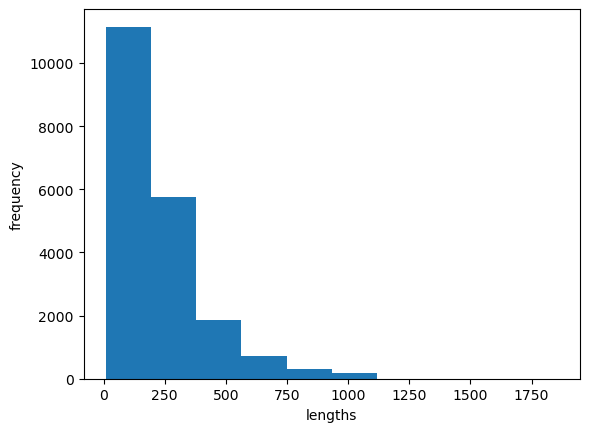

In [10]:
# lengths 배열을 히스토그램으로 표현
import matplotlib.pyplot as plt
plt.hist(lengths)
plt.xlabel('lengths')
plt.ylabel('frequency')
plt.show()

> 대부분의 리뷰 길이는 300 미만, 평균이 중간값보다 높은 이유는 오른쪽 끝에 아주 큰 데이터가 존재하기 때문

> 리뷰는 대부분 짧아서 이 예제에서는 중간값보다 훨씬 짧은 100개의 단어만 사용
- 하지만, 여전히 100개의 단어보다 작은 리뷰가 존재
- 이런 리뷰들의 길이를 100에 맞추기 위해 패딩이 필요함
 - 보통 패딩을 나타내는 토큰으로는 0을 사용함

>케라스는 시퀸스 데이터의 길이를 맞추는 pad_sequences() 함수를 제공

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)

> maxlen에 원하는 길이를 지정하면 이보다 긴 경우는 잘라내고 짧은 경우는 0으로 패딩을 함

In [12]:
# train_seq 크기 확인
print(train_seq.shape)

(20000, 100)


In [13]:
# train_seq의 첫번째 원소 출력
print(train_seq[0])

[ 10   4  20   9   2   2   2   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10   2   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10   2 158]


> 샘플의 앞 뒤에 0이 없는 것으로 보아 100보다 긴 샘플이었을 것으로 예상

In [14]:
# train_input에 있는 원본 샘플의 끝 확인
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 2, 158]


> train_input[0]의 마지막 10개의 토큰이 train_seq[0]의 출력값과 일치하는 것으로 보아 샘플의 앞부분이 잘렸다는것을 짐작할 수 있음

> pad_sequences() 함수는 기본으로 maxlen보다 긴 시퀀스의 앞부분을 자름
- 일반적으로 시퀀스의 뒷부분의 정보가 더 유용하리라 기대하기 때문
 - 영화 리뷰 끝에 결정적인 소감을 말할 가능성이 높다고 판단해서
- 만약, 시퀀스의 뒷부분을 잘라내고 싶다면 pad_sequences() 함수의 truncating 매개변수 값을 기본값 'pre'가 아닌 'post'로 바꾸면 됨

In [15]:
# train_seq의 여섯번째 샘플 출력
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2   2   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94   2   2   2   2  11 190
  24   2   2   7  94 205   2  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


> 앞부분에 0이 존재하는 것으로 보아 이 샘플의 길이는 100이 안됨
- 역시 같은 이유로 패딩 토큰은 시퀀스의 뒤가 아닌 앞 부분에 추가됨
 - 시퀀스의 마지막에 있는 단어가 셀의 은닉 상태에 가장 큰 영향을 미치므로 마지막에 패딩을 추가하는 것은 일반적으로 선호 X
- pad_sequences ()함수의 padding 매개변수를 기본갓 'pre'가 아닌 'post'로 바꾸면 샘플의 뒷 부분에 패딩 추가 가능

In [16]:
# 검증 세트의 길이 100
val_seq = pad_sequences(val_input, maxlen=100)

# 순환 신경망 만들기
> 케라스가 제공하는 가장 간단한 순환층 클래스는 SimpleRNN 클래스
- IMDB 리뷰 분류 문제는 이진 분류이므로 마지막 출력층은 1개의 뉴런을 가지고 시그모이드 함수 사용

>Sequential 클래스는 순환신경망을 만드는 용도 X
- 순환 신경망 뿐만 아니라 합성곱 신경망이나 일반적인 인공 신경망 모델을 모두 만들 수 있음

In [17]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 300)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

> 이 코드는 지금까지 보았던 구성과 매우 비슷
- 달라진 것은 Dense나 Conv2D 클래스 대신 SimpleRNN 클래스를 사용
 - 첫 번째 매개변수에는 사용할 뉴런의 개수를 지정하고 input_shape에 입력 차원을 (100, 300)으로 지정함
- 순환층도 당연히 활성화 함수를 사용 해야함
 - SimpleRNN 클래스의 activation 매개변수의 기본값은 'tanh'로 하이퍼볼릭 탄젠트 함수 사용


> inputshape의 입력 차원
- 첫 번째 차원인 100은 앞서 샘플의 길이를 100으로 지정했기 때문
- 두 번째 차원인 300은?

> train_seq와 val_seq에는 큰 문제가 존재
 - 토큰을 정수로 변환한 이 데이터를 신경망에 주입하면 큰 정수가 활성화 출력을 만들기 때문
  - 분명히 이 정수 사이에는 어떤 관련이 없음 (20번 토큰을 10번 토큰보다 중요시해야 할 이유X)


> 단순한 정숫값을 신경망에 입력하기 위한 다른 방식 : 원-핫 인코딩
- 정숫값에 있는 크기 속성을 없애고 각 정수를 고유하게 표현 가능


> ex) train_seq[0]의 첫 번째 토큰인 10을 원-핫 인코딩으로 바꾸면 0 0 0 0 0 0 0 0 0 0 1 ... 0 이 됨
- 열 한번째 원소만 1이고 나머지는 모두 0인 배열
- imdb.load_data() 함수에서 300개의 단어만 사용하도록 지정했기 때문에 고유한 단어는 모두 300개, 즉 훈련 데이터에 포함될 수 있는 정숫값의 범위는 0(패딩 토큰)에서 499까지이므로 이 범위를 원-핫 인코딩으로 표현하려면 배열의 길이가 300이어야 함

> "I am a boy"에 있는 각 단어를 숫자 3개를 사용해 표현하는 것 처럼 토큰마다 300개의 숫자를 사용해 표현하는 것, 다만 300개 중에 하나만 1이고 나머지는 모두 0으로 만들어 정수 사이에 있던 크기 속성을 없애는 원-핫 인코딩을 사용

> 케라스에는 원-핫 인코딩을 위한 유틸리티 제공
- keras.utils 패키지 아래에 있는 to_categorical() 함수는 정수 배열을 입력하면 자동으로 원-핫 인코딩된 배열을 반환해줌

In [18]:
train_oh = keras.utils.to_categorical(train_seq)

In [19]:
# train_seq을 원-핫 인코딩한 train_oh 배열의 크기 출력
print(train_oh.shape)

(20000, 100, 300)


> 정수 하나마다 모두 300차원의 배열로 변경되었기 때문에 (20000, 100)크기가 (20000, 100, 300) 크기로 바뀜

> 이렇게 샘플 데이터의 크기가 1차원 정수 배열(100, )에서 2차원 배열(100, 300)으로 바꿔야 하므로 SimpleRNN 클래스의 input_shape 매개변수의 값을 (100, 300)으로 지정한 것

In [20]:
# train_oh의 첫 번째 샘플의 첫 번째 토큰 10이 인코딩 되었는지 확인
print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


> 12개의 원소를 출력해보면 11번째 원소만 1이고 나머지 원소는 0인 것을 확인할 수 있음

In [21]:
# train_oh의 모든 원소의 합 출력
print(np.sum(train_oh[0][0]))

1.0


> 모든 원소의 합이 1인 것으로 보아 11번째 원소를 제외한 나머지 모든 원소가 0인 것을 확인할 수 있음

In [22]:
# 같은 방식으로 val_seq도 원-핫 인코딩
val_oh = keras.utils.to_categorical(val_seq)

In [23]:
# 앞서 만든 모델의 구조 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 2472      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 2481 (9.69 KB)
Trainable params: 2481 (9.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


> SimpleRNN에 전달한 샘플의 크기는 (100,300)이지만 이 순환층은 마지막 타임스텝의 은닉상태만 출력하기 때문에 출력 크기가 순환층의 뉴런 개수와 동일한 8임을 확인할 수 있음

> 순환층에 사용된 모델 파라미터의 개수
- 입력 토큰은 300차원의 원-핫 인코딩 배열, 이배열이 순환층의 뉴런 8개와 완전히 연결되기 때문에 300 x 8 = 2400개의 가중치가 있음
- 순환층의 은닉 상태는 다시 다음 타임스텝에 사용되기 위해 또 다른 가중치와 곱해짐, 이 은닉 상태도 순환층의 뉴런과 완전히 연결되기 때문에 8(은닉상태 크기) x 8(뉴런 개수) = 64개의 가중치가 필요함
- 마지막으로 뉴런마다 하나의 절편이 있기 때문에 모두 4000 + 64 + 8 = 4072개의 모델 파라미터가 필요함

# 순환 신경망 훈련하기

케라스 API를 사용하는 장점 덕분에 순환 신경망의 훈련은 다른 신경망들과 다르지 않음
- 다음 코드처럼 모델을 컴파일하고 훈련하는 전체 구조가 동일함
 - 아래 예시에서는 기본 RMSprop의 학습률 0.001을 사용하지 않기 위해 별도의 RMSprop 객체를 만들어 학습률을 0.0001로 지정
 - 에포크 횟수를 100으로 늘리고 배치 크기는 64로 설정
 - 그 밖에 체크포인트와 조기 종료를 구성하는 코드는 거의 동일

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

> 책에서의 결과: 훈련은 35번째 에포크에서 조기 종료되었고 검증 세트에 대한 정확도는 약 80%

In [ ]:
# 훈련손실과 검증 손실을 그래프로 그려서 훈련과정 살표보기
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlael('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

> 훈련 손실은 꾸준히 감소하고 있지만 검증 손실은 대략 스무번째 에포크에서 감소가 둔해지고 있음
- 적절한 에포크에서 훈련을 멈춘 것이 확인됨

> 이 작업을 위해 입력 데이터를 원-핫 인코딩으로 변환함

> 원-핫 인코딩의 단점은 입력 데이터가 엄청 커진다는 점
- 실제로 train_seq 배열과 train_oh 배열의 nbytes 속성을 출력하여 크기 확인

In [ ]:
print(train_seq.nbytes, train_oh.nbytes)

8000000 4000000000


> 토큰 1개를 300차원으로 늘렸기 때문에 대략 300배가 커짐
- 훈련 데이터가 커질수록 더 문제가 될 것으로 예상됨

# 단어 임베딩을 사용하기

> 순환 신경망에서 텍스트를 처리할 때 즐겨 사용하는 방법은 단어 임베딩(word embeding)임
- 단어 임베딩은 각 단어를 고정된 크기의 실수 벡터로 바꿔줌

예시
<pre>'cat'의 단어 임베딩 벡터
0.2 0.1 1.3 0.8 0.2 0.4 1.1 0.9 0.2 0.1

> 이런 단어 임베딩으로 만들어진 벡터는 원-핫 인코딩된 벡터보다 훨씬 의미 있는 값으로 채워져 있기 때문에 자연어 처리에서더 좋은 성능을 내는 경우가 많음
- keras.layers 패키지 아래 Embedding 클래스로 임베딩 기능 제공
- 이 클래스를 다른 층처럼 모델에 추가하면 처음에는 모든 벡터가 랜덤하게 초기화 되지만 훈련을 통해 데이터에서 좋은 단어 임베딩을 학습함

> 단어 임베딩의 장점은 입력으로 정수 데이터를 받는다는 것
- 즉 원-핫 인코딩으로 변경된 train_oh 배열이 아닌 train_seq을 사용할 수 있음
- 이때문에 메모리를 훨씬 효율적으로 사용 가능

> 임베도딩 원-핫 인코딩과 비슷하게 (100,) 크기의 샘플을 (100,20)과 같이 2차원으로 늘림
- 하지만 원-핫 인코딩과 달리 훨씬 작은 크기로도 단어를 잘 표현할 수 있음

In [ ]:
# Embedding 클래스를 SimpleRnn 층 앞에 추가한 두 번째 순환 신경망 생성
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(300, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

> Embedding 클래스의 첫 번째 매개변수(300)은 어휘 사전의 크기

> 두 번째 매개변수(16)는 임베딩 벡터의 크기, 여기서는 원-핫 인코딩 보다 훨씬 작은 크기 (16) 사용

> 세 번째 input_length 매개변수는 입력 시퀀스의 길이, 앞서 샘플의 길이를 100으로 맞추어 train_seq을 만들었기에 이 값을 100으로 지정

> 그 다음 SimpleRNN 층과 Dense 층은 이전과 동일함

In [ ]:
# model2.summary()

> 이 모델은 (100,) 크기의 입력을 받아 (100,16) 크기의 출력을 만듬

> 모델 파라미터 개수 계산
- Embedding 클래스는 300개의 각 토큰을 크기가 16인 벡터로 변경하기 때문에 총 300x16 = 4800개의 모델 파라미터 층을 가짐
- 그 다음 SimpleRNN 층은 임베딩 벡터의 크기가 16이므로 8개의 뉴런과 곱하기 위해 필요한 가중치 16 x 8 = 128개를 가짐
- 또한 은닉 상태에 곱해지는 가중치 8 x 8 =64개가 있음
- 마지막으로 8개의 절편을 합하면 전체 모델 파라미터의 개수는 128 + 64 + 8 = 200개




> 마지막 Dense 층의 가중치 개수는 이전과 동일하게 9개임

> 원-핫 인코딩 보다 SimpleRNN에 주입되는 입력의 크기가 크게 줄었지만 임베딩 벡터는 단어를 잘 표현하는 능력이 있기 때문에 훈련 결과는 이전에 못지 않을 것임

In [ ]:
# 모델 훈련 과정은 이전과 동일

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

> 출력 결과를 보면 원-핫 인코딩을 사용한 모델과 비슷한 성능을 냄
- 반면 순환층의 가중치 개수는 훨씬 작고 훈련 세트 크기도 훨씬 줄어들었음


In [ ]:
# 훈련 손실과 검증 손실을 그래프로 출력
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()